【已完成|运行中|待运行】:
[0|0|2].


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:96: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[0|2|0].
[

,group1,group10,benchmark,group1_temp,group10_temp,benchmark_temp,group1_temp_lag,group10_temp_lag,benchmark_temp_lag,group1_day_return,group10_day_return,benchmark_day_return,group1_value,group10_value,benchmark_value,1_10,1_benchmark,10_benchmark
1,0.008249,0.008621,0.003788,1.008249,1.008621,1.003788,0.995407,0.995422,0.992031,1.012901,1.013260,1.011852,1.012901,1.013260,1.011852,0.999646,1.001037,1.001391
2,0.027754,0.032780,0.029613,1.027754,1.032780,1.029613,1.008249,1.008621,1.003788,1.019345,1.023953,1.025727,1.032496,1.037530,1.037885,0.995149,0.994808,0.999658
3,0.026268,0.037279,0.033943,1.026268,1.037279,1.033943,1.027754,1.032780,1.029613,0.998554,1.004356,1.004206,1.031003,1.042050,1.042249,0.989400,0.989210,0.999808
4,0.032842,0.052123,0.041416,1.032842,1.052123,1.041416,1.026268,1.037279,1.033943,1.006406,1.014311,1.007227,1.037608,1.056962,1.049782,0.981689,0.988403,1.006839
5,0.021007,0.040965,0.029485,1.021007,1.040965,1.029485,1.032842,1.052123,1.041416,0.988541,0.989395,0.988543,1.025718,1.045752,1.037755,0.980842,0.988401,1.007706


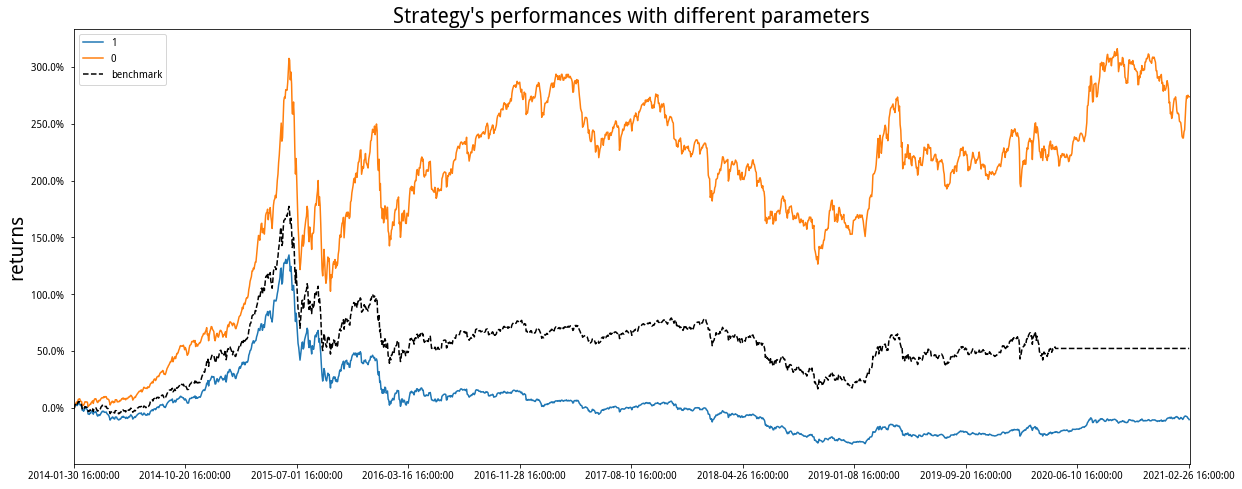

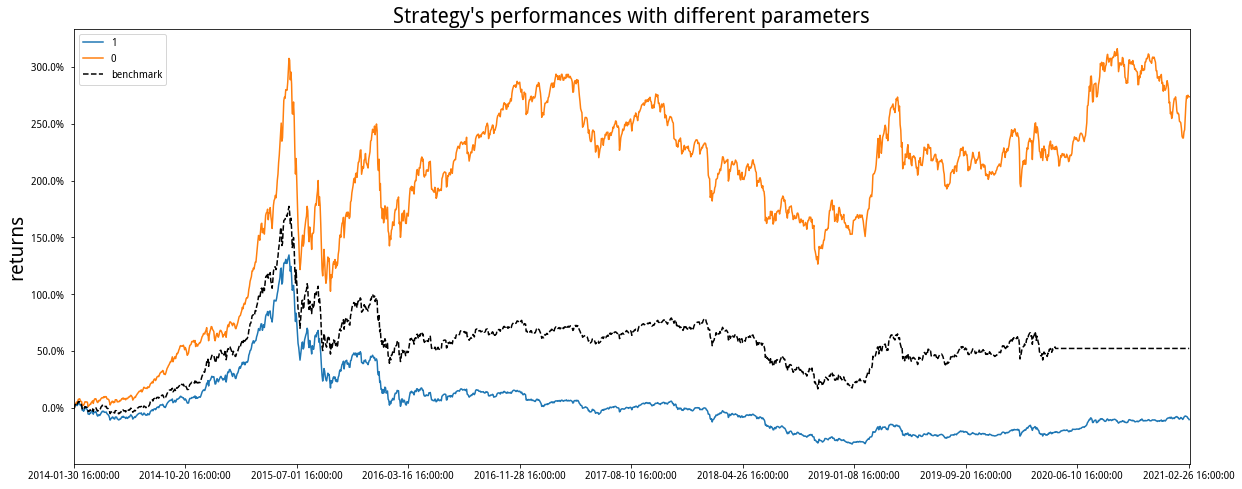

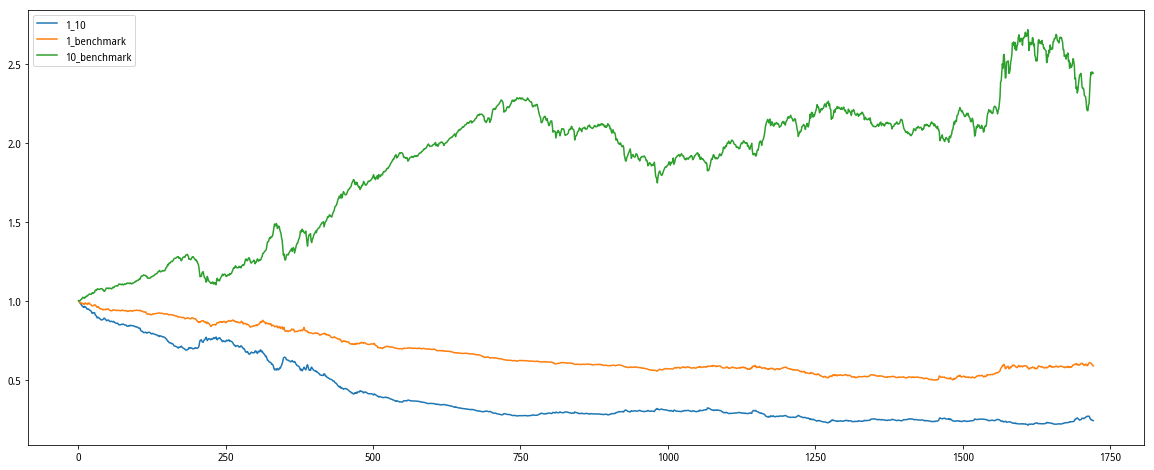

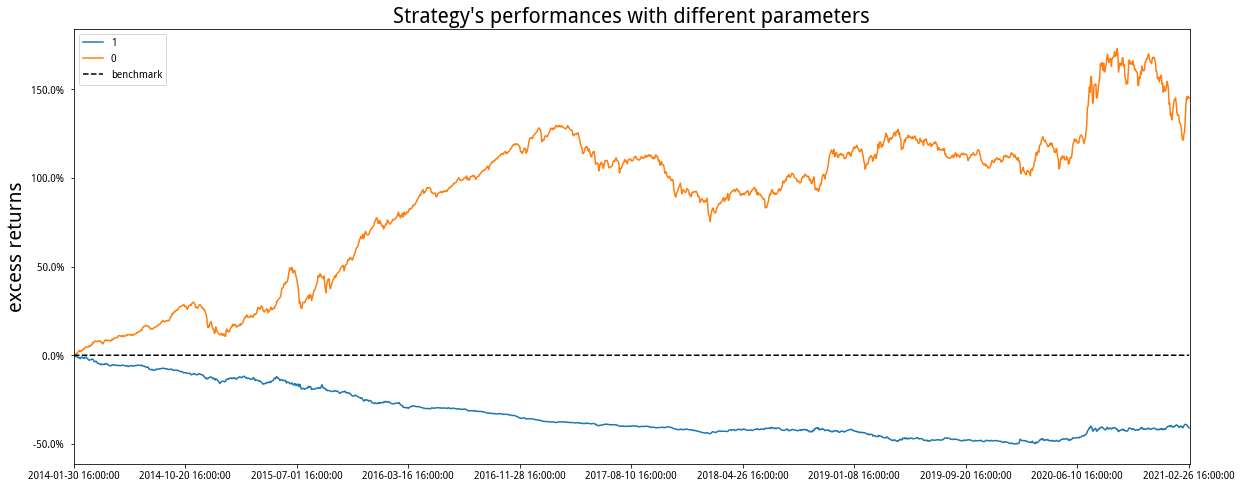

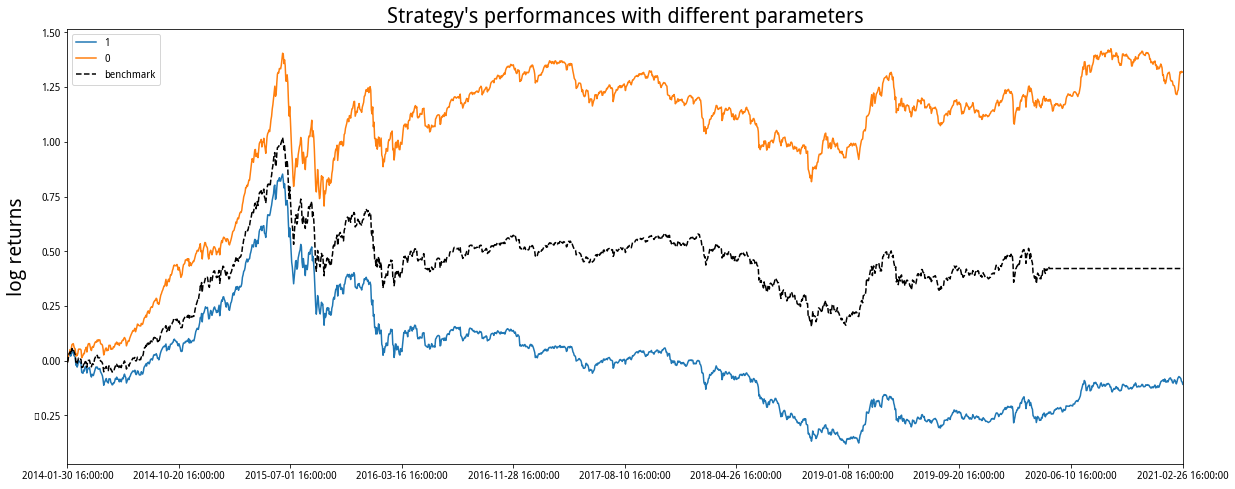

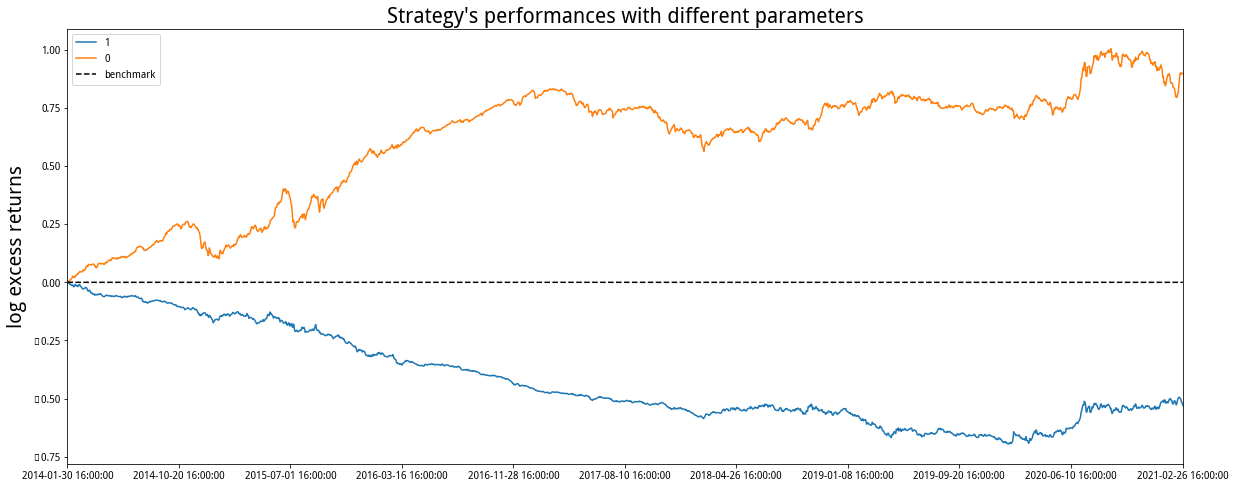

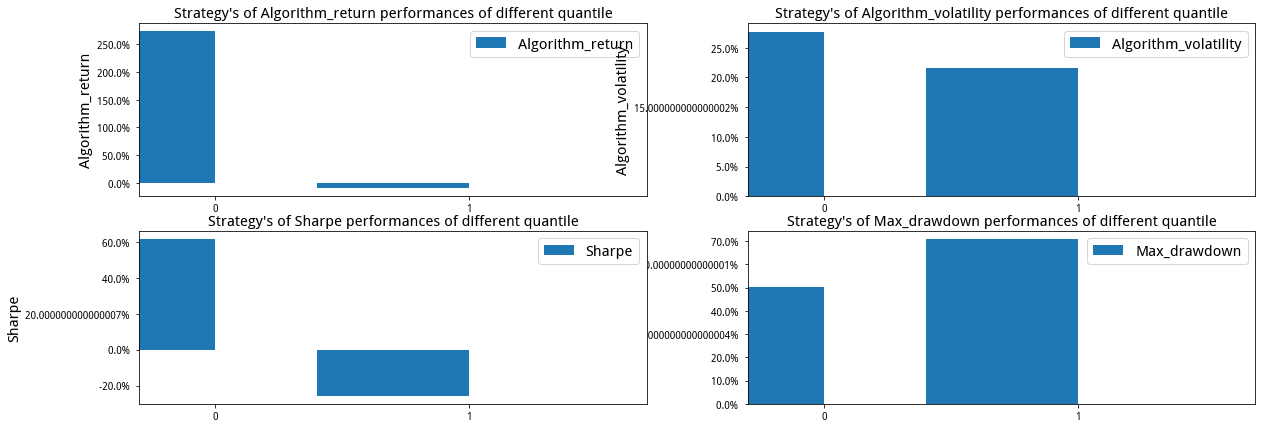

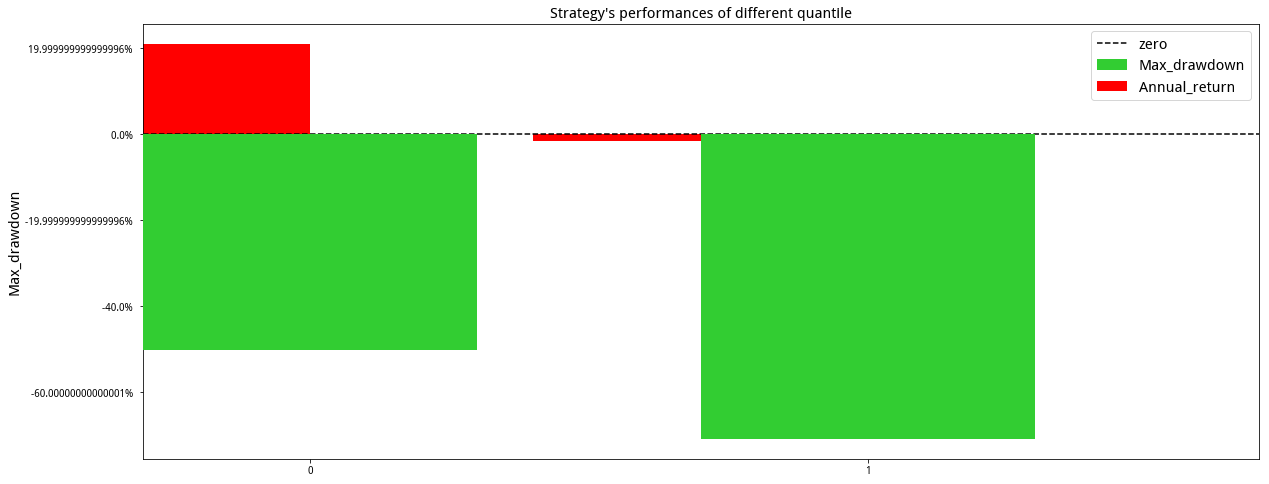

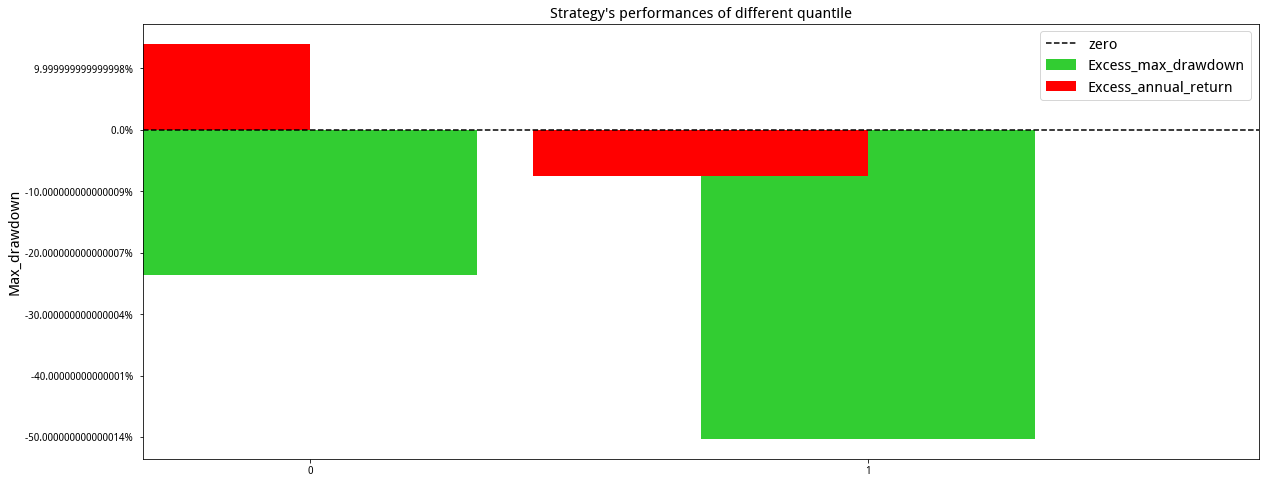

In [12]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from datetime import datetime, timedelta
import time
from sklearn import preprocessing
from scipy.stats import mstats
import scipy.stats as st
import seaborn as sns
import calendar
import statsmodels.api as sm
import matplotlib.pylab as plt
import xlrd
import itertools
import copy
import pickle
import warnings
from scipy import stats

# 定义类'参数分析'
class parameter_analysis(object):
    # 定义函数中不同的变量
    def __init__(self, algorithm_id=None):
        self.algorithm_id = algorithm_id  # 回测id

        self.params_df = pd.DataFrame()  # 回测中所有调参备选值的内容，列名字为对应修改面两名称，对应回测中的 g.XXXX
        self.results = {}  # 回测结果的回报率，key 为 params_df 的行序号，value 为
        self.evaluations = {}  # 回测结果的各项指标，key 为 params_df 的行序号，value 为一个 dataframe
        self.backtest_ids = {}  # 回测结果的 id

        # 新加入的基准的回测结果 id，可以默认为空 ''，则使用回测中设定的基准
        self.benchmark_id = ""

        self.benchmark_returns = []  # 新加入的基准的回测回报率
        self.returns = {}  # 记录所有回报率
        self.excess_returns = {}  # 记录超额收益率
        self.log_returns = {}  # 记录收益率的 log 值
        self.log_excess_returns = {}  # 记录超额收益的 log 值
        self.dates = []  # 回测对应的所有日期
        self.excess_max_drawdown = {}  # 计算超额收益的最大回撤
        self.excess_annual_return = {}  # 计算超额收益率的年化指标
        self.evaluations_df = pd.DataFrame()  # 记录各项回测指标，除日回报率外

    # 定义排队运行多参数回测函数
    def run_backtest(self,  #
                     algorithm_id=None,  # 回测策略id
                     running_max=10,  # 回测中同时巡行最大回测数量
                     start_date='2014-01-30',  # 回测的起始日期
                     end_date='2021-02-26',  # 回测的结束日期
                     frequency='day',  # 回测的运行频率
                     initial_cash='1000000',  # 回测的初始持仓金额
                     param_names=[],  # 回测中调整参数涉及的变量
                     param_values=[]  # 回测中每个变量的备选参数值
                     ):
        # 当此处回测策略的 id 没有给出时，调用类输入的策略 id
        if algorithm_id == None: algorithm_id = self.algorithm_id

        # 生成所有参数组合并加载到 df 中
        # 包含了不同参数具体备选值的排列组合中一组参数的 tuple 的 list
        param_combinations = list(itertools.product(*param_values))
        # 生成一个 dataframe， 对应的列为每个调参的变量，每个值为调参对应的备选值
        to_run_df = pd.DataFrame(param_combinations)
        # 修改列名称为调参变量的名字
        to_run_df.columns = param_names

        # 设定运行起始时间和保存格式
        start = time.time()
        # 记录结束的运行回测
        finished_backtests = {}
        # 记录运行中的回测
        running_backtests = {}
        # 计数器
        pointer = 0
        # 总运行回测数目，等于排列组合中的元素个数
        total_backtest_num = len(param_combinations)
        # 记录回测结果的回报率
        all_results = {}
        # 记录回测结果的各项指标
        all_evaluations = {}

        # 在运行开始时显示
        print ('【已完成|运行中|待运行】:')
        # 当运行回测开始后，如果没有全部运行完全的话：
        while len(finished_backtests) < total_backtest_num:
            # 显示运行、完成和待运行的回测个数
            print('[%s|%s|%s].' % (len(finished_backtests),
                                   len(running_backtests),
                                   (total_backtest_num - len(finished_backtests) - len(running_backtests)))),
            # 记录当前运行中的空位数量
            to_run = min(running_max - len(running_backtests),
                         total_backtest_num - len(running_backtests) - len(finished_backtests))

            # 把可用的空位进行跑回测
            for i in range(pointer, pointer + to_run):
                # 备选的参数排列组合的 df 中第 i 行变成 dict，每个 key 为列名字，value 为 df 中对应的值
                params = to_run_df.ix[i].to_dict()
                # 记录策略回测结果的 id，调整参数 extras 使用 params 的内容
                backtest = create_backtest(algorithm_id=algorithm_id,
                                           start_date=start_date,
                                           end_date=end_date,
                                           frequency=frequency,
                                           initial_cash=initial_cash,
                                           extras=params,
                                           # 再回测中把改参数的结果起一个名字，包含了所有涉及的变量参数值
                                           name=str(params),
                                           use_credit=True,
                                           )
                # 记录运行中 i 回测的回测 id
                running_backtests[i] = backtest
            # 计数器计数运行完的数量
            pointer = pointer + to_run

            # 获取回测结果
            failed = []
            finished = []
            # 对于运行中的回测，key 为 to_run_df 中所有排列组合中的序数
            for key in running_backtests.keys():
                # 研究调用回测的结果，running_backtests[key] 为运行中保存的结果 id
                bt = get_backtest(running_backtests[key])
                # 获得运行回测结果的状态，成功和失败都需要运行结束后返回，如果没有返回则运行没有结束
                status = bt.get_status()
                # 当运行回测失败
                if status == 'failed':
                    # 失败 list 中记录对应的回测结果 id
                    failed.append(key)
                # 当运行回测成功时
                elif status == 'done':
                    # 成功 list 记录对应的回测结果 id，finish 仅记录运行成功的
                    finished.append(key)
                    # 回测回报率记录对应回测的回报率 dict， key to_run_df 中所有排列组合中的序数， value 为回报率的 dict
                    # 每个 value 一个 list 每个对象为一个包含时间、日回报率和基准回报率的 dict
                    all_results[key] = bt.get_results()
                    # 回测回报率记录对应回测结果指标 dict， key to_run_df 中所有排列组合中的序数， value 为回测结果指标的 dataframe
                    all_evaluations[key] = bt.get_risk()
            # 记录运行中回测结果 id 的 list 中删除失败的运行
            for key in failed:
                running_backtests.pop(key)
            # 在结束回测结果 dict 中记录运行成功的回测结果 id，同时在运行中的记录中删除该回测
            for key in finished:
                finished_backtests[key] = running_backtests.pop(key)
            # 当一组同时运行的回测结束时报告时间
            if len(finished_backtests) != 0 and len(finished_backtests) % running_max == 0 and to_run != 0:
                # 记录当时时间
                middle = time.time()
                # 计算剩余时间，假设没工作量时间相等的话
                remain_time = (middle - start) * (total_backtest_num - len(finished_backtests)) / len(
                    finished_backtests)
                # print 当前运行时间
                print('[已用%s时,尚余%s时,请不要关闭浏览器].' % (str(round((middle - start) / 60.0 / 60.0, 3)),
                                                   str(round(remain_time / 60.0 / 60.0, 3)))),
            # 5秒钟后再跑一下
            time.sleep(5)
            # 记录结束时间
        end = time.time()

        print('【回测完成】总用时：%s秒(即%s小时)。' % (str(int(end - start)),
                                         str(round((end - start) / 60.0 / 60.0, 2)))),
        # 对应修改类内部对应
        self.params_df = to_run_df
        self.results = all_results
        self.evaluations = all_evaluations
        self.backtest_ids = finished_backtests

    # 7 最大回撤计算方法l
    def find_max_drawdown(self, returns):
        # 定义最大回撤的变量
        result = 0
        # 记录最高的回报率点
        historical_return = 0
        # 遍历所有日期
        for i in range(len(returns)):
            # 最高回报率记录
            historical_return = max(historical_return, returns[i])
            # 最大回撤记录
            drawdown = 1 - (returns[i] + 1) / (historical_return + 1)
            # 记录最大回撤
            result = max(drawdown, result)
        # 返回最大回撤值
        return result

    # log 收益、新基准下超额收益和相对与新基准的最大回撤
    def organize_backtest_results(self, benchmark_id=None):
        # 若新基准的回测结果 id 没给出
        if benchmark_id == None:
            # 使用默认的基准回报率，默认的基准在回测策略中设定
            self.benchmark_returns = [x['benchmark_returns'] for x in self.results[0]]
        #   print ('self.results is :', self.results)
        # {0: [{u'returns': -0.02343786499999989, u'benchmark_returns': -0.02071061524003759,
        #       u'time': u'2012-01-04 16:00:00'},
        #      {u'returns': -0.038695864999999885, u'benchmark_returns': -0.036710455281626975,
        #       u'time': u'2012-01-05 16:00:00'},
        #      {u'returns': -0.0314148649999999, u'benchmark_returns': -0.031143902585327954,
        #       u'time': u'2012-01-06 16:00:00'}...]
        #  1: [{u'returns': -0.031854872999999895, u'benchmark_returns': -0.02071061524003759,
        #       u'time': u'2012-01-04 16:00:00'},
        #       {u'returns': -0.0692748729999999, u'benchmark_returns': -0.036710455281626975,
        #       u'time': u'2012-01-05 16:00:00'},}
        # 当新基准指标给出后
        else:
            # 基准使用新加入的基准回测结果
            self.benchmark_returns = [x['returns'] for x in get_backtest(benchmark_id).get_results()]
        # 回测日期为结果中记录的第一项对应的日期
        self.dates = [x['time'] for x in self.results[0]]

        # 对应每个回测在所有备选回测中的顺序 （key），生成新数据
        # 由 {key：{u'benchmark_returns': 0.022480100091729405,
        #           u'returns': 0.03184566700000002,
        #           u'time': u'2006-02-14'}} 格式转化为：
        # {key: []} 格式，其中 list 为对应 date 的一个回报率 list
        for key in self.results.keys():
            self.returns[key] = [x['returns'] for x in self.results[key]]

        # 生成对于基准（或新基准）的超额收益率
        for key in self.results.keys():
            self.excess_returns[key] = [(x + 1) / (y + 1) - 1 for (x, y) in
                                        zip(self.returns[key], self.benchmark_returns)]
        # 生成 log 形式的收益率
        for key in self.results.keys():
            self.log_returns[key] = [log(x + 1) for x in self.returns[key]]
        # 生成超额收益率的 log 形式
        for key in self.results.keys():
            self.log_excess_returns[key] = [log(x + 1) for x in self.excess_returns[key]]
        # 生成超额收益率的最大回撤
        for key in self.results.keys():
            self.excess_max_drawdown[key] = self.find_max_drawdown(self.excess_returns[key])
        # 生成年化超额收益率
        for key in self.results.keys():
            self.excess_annual_return[key] = (self.excess_returns[key][-1] + 1) ** (252. / float(len(self.dates))) - 1
        # 把调参数据中的参数组合 df 与对应结果的 df 进行合并
        self.evaluations_df = pd.concat([self.params_df, pd.DataFrame(self.evaluations).T], axis=1)


    # 获取最总分析数据，调用排队回测函数和数据整理的函数
    def get_backtest_data(self,
                          algorithm_id=None,  # 回测策略id
                          benchmark_id=None,  # 新基准回测结果id
                          file_name='results.pkl',  # 保存结果的 pickle 文件名字
                          running_max=10,  # 最大同时运行回测数量
                          start_date='2006-01-01',  # 回测开始时间
                          end_date='2016-11-30',  # 回测结束日期
                          frequency='day',  # 回测的运行频率
                          initial_cash='1000000',  # 回测初始持仓资金
                          param_names=[],  # 回测需要测试的变量
                          param_values=[]  # 对应每个变量的备选参数
                          ):
        # 调运排队回测函数，传递对应参数
        self.run_backtest(algorithm_id=algorithm_id,
                          running_max=running_max,
                          start_date=start_date,
                          end_date=end_date,
                          frequency=frequency,
                          initial_cash=initial_cash,
                          param_names=param_names,
                          param_values=param_values
                          )
        # 回测结果指标中加入 log 收益率和超额收益率等指标
        self.organize_backtest_results(benchmark_id)
        # 生成 dict 保存所有结果。
        results = {'returns': self.returns,
                   'excess_returns': self.excess_returns,
                   'log_returns': self.log_returns,
                   'log_excess_returns': self.log_excess_returns,
                   'dates': self.dates,
                   'benchmark_returns': self.benchmark_returns,
                   'evaluations': self.evaluations,
                   'params_df': self.params_df,
                   'backtest_ids': self.backtest_ids,
                   'excess_max_drawdown': self.excess_max_drawdown,
                   'excess_annual_return': self.excess_annual_return,
                   'evaluations_df': self.evaluations_df}
        # 保存 pickle 文件
        pickle_file = open(file_name, 'wb')
        pickle.dump(results, pickle_file)
        pickle_file.close()

    # 读取保存的 pickle 文件，赋予类中的对象名对应的保存内容
    def read_backtest_data(self, file_name='results.pkl'):
        pickle_file = open(file_name, 'rb')
        results = pickle.load(pickle_file)
        self.returns = results['returns']
        self.excess_returns = results['excess_returns']
        self.log_returns = results['log_returns']
        self.log_excess_returns = results['log_excess_returns']
        self.dates = results['dates']
        self.benchmark_returns = results['benchmark_returns']
        self.evaluations = results['evaluations']
        self.params_df = results['params_df']
        self.backtest_ids = results['backtest_ids']
        self.excess_max_drawdown = results['excess_max_drawdown']
        self.excess_annual_return = results['excess_annual_return']
        self.evaluations_df = results['evaluations_df']

    # 回报率折线图:累积收益率
    def plot_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20, 8))
        ax = fig.add_subplot(111)
        df = pd.DataFrame()
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.returns[key])), self.returns[key], label=key)
            df = pd.concat([df, pd.Series(self.returns[key])], axis=1)
        # df.index = self.dates
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), self.benchmark_returns, label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates) - 1, 11)]
        # x坐标的标注
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc=2, fontsize=10)
        # 设置y标签样式
        ax.set_ylabel('returns', fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x * 100) + '% ' for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        #x轴上的最大值和最小值:
        plt.xlim(0, len(self.returns[0]))
        # df = pd.concat([df,pd.DataFrame(self.benchmark_returns)],axis = 1)
        # df.columns = ['group1', 'group2', 'group3', 'group4', 'group5', 'group6', 'group7', 'group8', 'group9',
        #              'group10']
        df.columns = ['group1','group10']

        return df, self.benchmark_returns

    # 超额收益率图
    def plot_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20, 8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.excess_returns[key])), self.excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [0] * len(self.benchmark_returns), label='benchmark', c='k',
                linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates) - 1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc=2, fontsize=10)
        # 设置y标签样式
        ax.set_ylabel('excess returns', fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x * 100) + '% ' for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.excess_returns[0]))

    # log回报率图
    def plot_log_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20, 8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.log_returns[key])), self.log_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [log(x + 1) for x in self.benchmark_returns], label='benchmark',
                c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates) - 1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc=2, fontsize=10)
        # 设置y标签样式
        ax.set_ylabel('log returns', fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_returns[0]))

    # 超额收益率的 log 图
    def plot_log_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20, 8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.log_excess_returns[key])), self.log_excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [0] * len(self.benchmark_returns), label='benchmark', c='k',
                linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates) - 1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc=2, fontsize=10)
        # 设置y标签样式
        ax.set_ylabel('log excess returns', fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_excess_returns[0]))

    # 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动
    def get_eval4_bar(self, sort_by=[]):
        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index

        fig = plt.figure(figsize=(20, 7))

        # 定义位置
        ax1 = fig.add_subplot(221)
        # 设定横轴为对应分位，纵轴为对应指标
        ax1.bar(range(len(indices)),
                [self.evaluations[x]['algorithm_return'] for x in indices], 0.6, label='Algorithm_return')
        plt.xticks([x + 0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax1.legend(loc='best', fontsize=15)
        # 设置y标签样式
        ax1.set_ylabel('Algorithm_return', fontsize=15)
        # 设置y标签样式
        ax1.set_yticklabels([str(x * 100) + '% ' for x in ax1.get_yticks()])
        # 设置图片标题样式
        ax1.set_title("Strategy's of Algorithm_return performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax2 = fig.add_subplot(224)
        # 设定横轴为对应分位，纵轴为对应指标
        ax2.bar(range(len(indices)),
                [self.evaluations[x]['max_drawdown'] for x in indices], 0.6, label='Max_drawdown')
        plt.xticks([x + 0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax2.legend(loc='best', fontsize=15)
        # 设置y标签样式
        ax2.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax2.set_yticklabels([str(x * 100) + '% ' for x in ax2.get_yticks()])
        # 设置图片标题样式
        ax2.set_title("Strategy's of Max_drawdown performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax3 = fig.add_subplot(223)
        # 设定横轴为对应分位，纵轴为对应指标
        ax3.bar(range(len(indices)),
                [self.evaluations[x]['sharpe'] for x in indices], 0.6, label='Sharpe')
        plt.xticks([x + 0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax3.legend(loc='best', fontsize=15)
        # 设置y标签样式
        ax3.set_ylabel('Sharpe', fontsize=15)
        # 设置x标签样式
        ax3.set_yticklabels([str(x * 100) + '% ' for x in ax3.get_yticks()])
        # 设置图片标题样式
        ax3.set_title("Strategy's of Sharpe performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax4 = fig.add_subplot(222)
        # 设定横轴为对应分位，纵轴为对应指标
        ax4.bar(range(len(indices)),
                [self.evaluations[x]['algorithm_volatility'] for x in indices], 0.6, label='Algorithm_volatility')
        plt.xticks([x + 0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax4.legend(loc='best', fontsize=15)
        # 设置y标签样式
        ax4.set_ylabel('Algorithm_volatility', fontsize=15)
        # 设置x标签样式
        ax4.set_yticklabels([str(x * 100) + '% ' for x in ax4.get_yticks()])
        # 设置图片标题样式
        ax4.set_title("Strategy's of Algorithm_volatility performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

    # 14 年化回报和最大回撤，正负双色表示
    def get_eval(self, sort_by=[]):
        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index

        # 大小
        fig = plt.figure(figsize=(20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x + 0.3 for x in range(len(indices))],
               [-self.evaluations[x]['max_drawdown'] for x in indices], color='#32CD32',
               width=0.6, label='Max_drawdown', zorder=10)
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.evaluations[x]['annual_algo_return'] for x in indices], color='r',
               width=0.6, label='Annual_return')
        plt.xticks([x + 0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best', fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k',
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best', fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x * 100) + '% ' for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))

    # 14 超额收益的年化回报和最大回撤
    # 加入新的benchmark后超额收益和
    def get_excess_eval(self, sort_by=[]):
        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index

        # 大小
        fig = plt.figure(figsize=(20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x + 0.3 for x in range(len(indices))],
               [-self.excess_max_drawdown[x] for x in indices], color='#32CD32',
               width=0.6, label='Excess_max_drawdown')
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.excess_annual_return[x] for x in indices], color='r',
               width=0.6, label='Excess_annual_return')
        plt.xticks([x + 0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best', fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k',
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best', fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x * 100) + '% ' for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))


# 2 设定策略 id ，此处注意，要换成自己的单因子策略id
pa = parameter_analysis('cf651e0fae0b6b9cafc7cfa69fe13d46')
# 3 运行回测
pa.get_backtest_data(file_name='results.pkl',
                     running_max=10,
                     benchmark_id=None,
                     start_date='2014-01-30',  # 回测的起始日期
                     end_date='2021-02-26',  # 回测的结束日期
                     frequency='day',
                     initial_cash='1000000',
                     param_names=['group'],
                     param_values=[(1,10)] # 因子，自己设定，测试哪个就写哪个
                     )

#4 数据读取
pa.read_backtest_data('results.pkl')

#5 回测参数的 Dataframe
print('5 回测参数的 Dataframe：')
pa.params_df

#  factor quantile
# 0	BP	  (0, 10)
# 1	BP	  (10, 20)
# 2	BP	  (20, 30)
# 3	BP	  (30, 40)
# 4	BP	  (40, 50)
# 5	BP	  (50, 60)
# 6	BP	  (60, 70)
# 7	BP	  (70, 80)
# 8	BP	  (80, 90)
# 9	BP	  (90, 100)

#6 查看回测结果指标
print('6 查看回测结果指标：')
pa.evaluations_df 

#7 获取10组回报率数据，同时绘制回报率折线图
returns_data = pa.plot_returns()[0]
print('7........')
returns_data.head()
# # group1	group2	     group3	      group4	group5	      group6	  group7	 group8	   group9	group10
# # 0	-0.023890	-0.029486	-0.028886	-0.033396	-0.033515	-0.030476	-0.035362	-0.034364	-0.034777	-0.031759
# # 1	-0.039120	-0.050287	-0.051885	-0.060467	-0.068155	-0.063370	-0.067297	-0.070395	-0.074504	-0.068472

#8 获取benchmark收益率，并与1-10组合并
benchmark_data = pd.Series(pa.plot_returns()[1])
benchmark_data.name = 'benchmark'
returns_data = pd.concat([returns_data,benchmark_data], axis=1)
print('8........')
returns_data.head()
# group1	group2	group3	group4	group5	group6	group7	group8	group9	group10	benchmark
# 0	-0.023890	-0.029486	-0.028886	-0.033396	-0.033515	-0.030476	-0.035362	-0.034364	-0.034777	-0.031759	-0.020711
# 1	-0.039120	-0.050287	-0.051885	-0.060467	-0.068155	-0.063370	-0.067297	-0.070395	-0.074504	-0.068472	-0.036710

# 9 绘制第一组的净值除以第十组和benchmark组的净值，检验做多第一组做空第十组和仅仅做多第一组的效应，以此来检验因子是否具有很好的选股功能
returns_data['group1_temp'] =  1+returns_data['group1']
returns_data['group10_temp'] = 1+returns_data['group10']
returns_data['benchmark_temp'] = 1+returns_data['benchmark']
returns_data['group1_temp_lag'] = returns_data['group1_temp'].shift(1)
returns_data['group10_temp_lag'] = returns_data['group10_temp'].shift(1)
returns_data['benchmark_temp_lag'] = returns_data['benchmark_temp'].shift(1)
returns_data = returns_data.dropna()
returns_data['group1_day_return'] = returns_data['group1_temp']/returns_data['group1_temp_lag']
returns_data['group10_day_return'] = returns_data['group10_temp']/returns_data['group10_temp_lag']
returns_data['benchmark_day_return'] = returns_data['benchmark_temp']/returns_data['benchmark_temp_lag']
returns_data['group1_value'] = returns_data['group1_day_return'].cumprod()
returns_data['group10_value'] = returns_data['group10_day_return'].cumprod()
returns_data['benchmark_value'] = returns_data['benchmark_day_return'].cumprod()
returns_data['1_10'] = returns_data['group1_value']/returns_data['group10_value']
returns_data['1_benchmark'] = returns_data['group1_value']/returns_data['benchmark_value']
returns_data['10_benchmark'] = returns_data['group10_value']/returns_data['benchmark_value']
print ('9.........')
returns_data.head()

#10
#绘制第一组除以第十组的净值曲线
#曲线一直上升，说明做多第一组做空第十组有效
#绘制第一组除以benchmark组的净值曲线
#曲线一直上升，说明做多第一组可以带来超额收益
#绘制第十组除以benchmark组的净值曲线
#曲线一直下降，说明做空第十组也可以带来超额收益（注意，做空第十组带来的超额收益的无效的，因为股票不可能做空）
#我们期望的是超额收益最好全部来自做多第一组
print ('10........')
plt.figure(figsize=(20,8))
returns_data['1_10'].plot()
returns_data['1_benchmark'].plot()
returns_data['10_benchmark'].plot()
plt.legend()
#11 超额收益率图
print ('11........')
pa.plot_excess_returns()
#12 log回报率图
print ('12........')
pa.plot_log_returns()
#13 超额收益率的 log 图
print ('13........')
pa.plot_log_excess_returns()
#14 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动
print ('14........')
pa.get_eval4_bar()
#15 年化回报和最大回撤，正负双色显示
print ('15........')
pa.get_eval()
#16 超额收益的年化回报和最大回撤
print ('16........')
pa.get_excess_eval()

#returns_data.head()
# group1	group2	group3	group4	group5	group6	group7	group8	group9	group10	...	benchmark_temp_lag	group1_day_return	group10_day_return	benchmark_day_return	group1_value	group10_value	benchmark_value	1_10	1_benchmark	10_benchmark
# 1	-0.039120	-0.050287	-0.051885	-0.060467	-0.068155	-0.063370	-0.067297	-0.070395	-0.074504	-0.068472	...	0.979289	0.984397	0.962083	0.983662	0.984397	0.962083	0.983662	1.023194	1.000748	0.978063
# 2	-0.032101	-0.044227	-0.046193	-0.051657	-0.060397	-0.056941	-0.062961	-0.069924	-0.080185	-0.065864	...	0.963290	1.007305	1.002800	1.005779	0.991588	0.964776	0.989346	1.027791	1.002266	0.975166
# 3	-0.001736	-0.009997	-0.008340	-0.009993	-0.017490	-0.021518	-0.022733	-0.029277	-0.044373	-0.035997	...	0.968856	1.031372	1.031973	1.035596	1.022696	0.995623	1.024562	1.027192	0.998179	0.971754
# 4	0.032471	0.029249	0.031925	0.031828	0.024941	0.018146	0.020193	0.011831	-0.000785	0.000186	...	1.003343	1.034266	1.037534	1.035165	1.057740	1.032993	1.060591	1.023957	0.997312	0.973978
# 5	0.027002	0.025684	0.028730	0.029135	0.021572	0.020451	0.017706	0.010815	0.004312	0.001489	...	1.038626	0.994703	1.001303	0.996454	1.052138	1.034339	1.056831	1.017208	0.995559	0.978718